### Calculate the policy of the agent
* State Variable: x = [w, n_lag, h_lag, e, s, A], action variable a = [c, b, k, h], both of them are numpy array 

In [1]:
%pylab inline
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from interpolation.splines import CubicSpline, LinearSpline
from scipy.interpolate import RegularGridInterpolator as RS
from multiprocessing import Pool
from functools import partial 
from pyswarm import pso
import warnings
from scipy import optimize

warnings.filterwarnings("ignore")
np.printoptions(precision=2)
# time line
T_min = 0
T_max = 70
T_R = 45
beta = 1/(1+0.02)
# All the money amount are denoted in thousand dollars
earningShock = [0.8,1.2]
# Define transition matrix of economical states
# GOOD -> GOOD 0.8, BAD -> BAD 0.6 
Ps = np.array([[0.6, 0.4],[0.2, 0.8]])
# current risk free interest rate 
r_f = np.array([0.01 ,0.03])
# stock return depends on current and future econ states
r_m = np.array([[-0.2, 0.15],[-0.15, 0.2]])
# expected return on stock market 
r_bar = 0.0667
# probability of survival
Pa = np.load("prob.npy")
# probability of employment transition 
Pe = np.array([[[[0.3, 0.7], [0.1, 0.9]], [[0.25, 0.75], [0.05, 0.95]]],
               [[[0.25, 0.75], [0.05, 0.95]], [[0.2, 0.8], [0.01, 0.99]]]])
# deterministic income
detEarning = np.load("detEarning.npy")
# tax rate 
tau_L = 0.2
tau_R = 0.1
# minimum consumption
r_bar = 0.02
c_bar = 3

Populating the interactive namespace from numpy and matplotlib


In [2]:
import nevergrad as ng
optimizer = ng.optimizers.OnePlusOne(parametrization=2, budget=100)
optimizer.parametrization.register_cheap_constraint(lambda x: x[0] >= 0)
optimizer.parametrization.register_cheap_constraint(lambda x: x[0] <= 1)
optimizer.parametrization.register_cheap_constraint(lambda x: x[1] >= 0)
optimizer.parametrization.register_cheap_constraint(lambda x: x[1] <= 1)

In [3]:
#Define the new utility function as a funciton of consumption good cost and renting
def u(c, h):
    alpha = 0.88
    kappa = 0
    gamma = 2
    ch = np.float_power(max(c-c_bar,0),alpha) * np.float_power((1+kappa)*h,1-alpha)
    return (np.float_power(ch,1-gamma) - 1)/(1 - gamma)

#Define the bequeath function, which is a function of wealth 
def uB(w):
    B = 2
    gamma = 2
    return B*(np.float_power(max(w+1,0),1-gamma) - 1)/(1 - gamma)

#Define the earning function 
def y(t, x):
    w, n, h_lag, s, e, A = x
    if A == 0:
        return 0
    else:
        if t <= T_R:
            return detEarning[t] * earningShock[int(s)] * e + (1-e)*5
        else:
            return detEarning[t]

# Define the reward funtion
def R(x, a):
    c, b, k, h = a
    w, n, h_lag, s, e, A = x
    if A == 0:
        return uB(w+n)
    else:
        return u(c,h)

# Define the transtiion of state (test)
def transition(x, a, t):
    '''
        Input: x current state: (w, n, h_lag, e, s, A) 
               a action taken: (c, b, k, h)
        Output: the next possible states with corresponding probabilities
    '''
    c, b, k, h = a
    w, n, h_lag, s, e, A = x
    
    x_next = []
    prob_next = []
    # Agent is dead 
    if A == 0:
        for s_next in [0, 1]:
            x_next.append([0, 0, 0, s_next, 0, 0])
        return np.array(x_next), Ps[int(s)]
    else:
        # variables needed
        N = np.sum(Pa[t:])
        discounting = ((1+r_bar)**N - 1)/(r_bar*(1+r_bar)**N)
        Pat = [1-Pa[t], Pa[t]]
        r_bond = r_f[int(s)]
        # calcualte n_next 
        if t < T_R:
            # before retirement agents put 5% of income to 401k
            if e == 1:
                n_next = (n+0.05*y(t,x))*(1+r_bar)
            else:
                n_next = n*(1+r_bar)
                
            # for potential s_next, e_next and A_next 
            for s_next in [0, 1]:
                r_stock = r_m[int(s), s_next]
                w_next =  b*(1+r_bond) + k*(1+r_stock)
                for e_next in [0,1]:
                    for A_next in [0,1]:
                        x_next.append([w_next, n_next, h, s_next, e_next, A_next])
                        prob_next.append(Ps[int(s),s_next] * Pat[A_next] * Pe[int(s),s_next,int(e),e_next])    
                
        else:
            # after retirement agents withdraw cash from 401k
            n_next = n*(1+r_bar)-n/discounting
            e_next = 0
            
            # for potential s_next and A_next
            for s_next in [0, 1]:
                r_stock = r_m[int(s), s_next]
                w_next =  b*(1+r_bond) + k*(1+r_stock)
                for A_next in [0,1]:
                    x_next.append([w_next, n_next, h, s_next, e_next, A_next])
                    prob_next.append(Pat[A_next] * Ps[int(s), s_next]) 
    return np.array(x_next), np.array(prob_next) 
    
# Value function is a function of state and time t
def V(x, t, Vmodel):
    # Define the objective function as a function of action
    potentialH = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
    w, n, h_lag, s, e, A = x
    if A == 0:
        return np.array([R(x,[0,0,0,0]),[0,0,0,0]])
    else: 
        N = np.sum(Pa[t:])
        discounting = ((1+0.02)**N - 1)/(r_bar*(1+0.02)**N)
        n_discount = n/discounting
        pr = 2
        ytx = y(t, x)
        def obj(thetas, h):
            theta1, theta2 = thetas
            if t < T_R:
                if e == 1:
                    bk = ((1-tau_L)*(ytx * 0.95) + w) * theta1
                    ch = ((1-tau_L)*(ytx * 0.95) + w) *(1-theta1)
                else:
                    bk = ((1-tau_L)*ytx + w) * theta1
                    ch = ((1-tau_L)*ytx + w) * (1-theta1)
            else:
                bk = ((1-tau_R)*ytx + w + n_discount) * theta1
                ch = ((1-tau_R)*ytx + w + n_discount) * (1-theta1)
                
            b = bk * theta2
            k = bk * (1-theta2)
            c = ch - pr*h - 5*(h != h_lag)
            if c <= c_bar:
                return 999999999
            a = (c,b,k,h)
            x_next, prob_next = transition(x, a, t)
            return -(R(x, a) + beta * np.dot(Vmodel[int(s)][int(e)][int(A)](x_next[:,:3]), prob_next))
        
        xopts = []
        fopts = []
        for hval in potentialH:
            xopt = optimizer.minimize(partial(obj, h = hval)).value
            xopts.append(xopt)
            fopts.append(-partial(obj, h = hval)(xopt))
        
        index = np.argmax(fopts)
        max_val = fopts[index]
        theta1_m, theta2_m = xopts[index]
        h_m = potentialH[index]
        
        if t < T_R:
            if e == 1:
                bk_m = ((1-tau_L)*(ytx * 0.95) + w) * theta1_m
                ch_m = ((1-tau_L)*(ytx * 0.95) + w) * (1-theta1_m)
            else:
                bk_m = ((1-tau_L)*ytx + w) * theta1_m
                ch_m = ((1-tau_L)*ytx + w) * (1-theta1_m)
        else:
            bk_m = ((1-tau_R)*ytx + w + n_discount) * theta1_m
            ch_m = ((1-tau_R)*ytx + w + n_discount) * (1-theta1_m)
            
        b_m = bk_m * theta2_m
        k_m = bk_m * (1-theta2_m)
        c_m = ch_m - pr*h_m - 5*(h_m != h_lag)
        return np.array([max_val, [c_m, b_m, k_m, h_m]])

In [5]:
# wealth discretization 
w_grid_size = 50
w_lower = 5
w_upper = 20000
# 401k amount discretization 
n_grid_size = 50
n_lower = 5
n_upper = 20000
# housing consumption discretization
h_grid_size = 50
h_lower = 2
h_upper = 100

def powspace(start, stop, power, num):
    return np.linspace(start, stop, num=num)

# initialize the state discretization 
x_T = np.array([[w,n,h_lag,e,s,0]   for w in powspace(w_lower, w_upper, 3, w_grid_size)
                            for n in powspace(n_lower, n_upper, 3, n_grid_size)
                            for h_lag in powspace(h_lower, h_upper, 3, h_grid_size)
                            for s in [0,1]
                            for e in [0,1]
                            for A in [0,1]]).reshape((w_grid_size, n_grid_size, h_grid_size, 2,2,2,6))

xgrid = np.array([[w,n,h_lag,e,s,A] for w in powspace(w_lower, w_upper, 3, w_grid_size)
                            for n in powspace(n_lower, n_upper, 3, n_grid_size)
                            for h_lag in powspace(h_lower, h_upper, 3, h_grid_size)
                            for s in [0,1]
                            for e in [0,1]
                            for A in [0,1]]).reshape((w_grid_size, n_grid_size, h_grid_size, 2,2,2,6))

Vgrid = np.zeros((w_grid_size, n_grid_size, h_grid_size, 2, 2, 2, T_max+1))
cgrid = np.zeros((w_grid_size, n_grid_size, h_grid_size, 2, 2, 2, T_max+1))
bgrid = np.zeros((w_grid_size, n_grid_size, h_grid_size, 2, 2, 2, T_max+1))
kgrid = np.zeros((w_grid_size, n_grid_size, h_grid_size, 2, 2, 2, T_max+1))
hgrid = np.zeros((w_grid_size, n_grid_size, h_grid_size, 2, 2, 2, T_max+1))

# apply function to state space, need to reshape the matrix and shape it back to the size
def applyFunToCalculateValue(fun, x = xgrid):
    return np.array(list(map(fun, x.reshape((w_grid_size * n_grid_size * h_grid_size* 2 * 2 * 2, 6))))).reshape((w_grid_size, n_grid_size,h_grid_size,2,2,2))

Vgrid[:,:,:,:,:,:, T_max] = applyFunToCalculateValue(partial(R, a = [0,0,0,0]), x = x_T)

### Backward Induction Part

In [6]:
%%time 
ws = powspace(w_lower, w_upper, 3, w_grid_size)
ns = powspace(n_lower, n_upper, 3, n_grid_size)
hs = powspace(h_lower, h_upper, 3, h_grid_size)



xs = xgrid.reshape((w_grid_size * n_grid_size * h_grid_size * 2 * 2 * 2, 6))

pool = Pool()

for t in range(T_max-1, T_max-5, -1):
    print(t)
    cs = [[[RS((ws,ns,hs), Vgrid[:,:,:,s,e,A,t+1]) for A in [0,1]] for e in [0,1]] for s in [0,1]]
    f = partial(V, t = t, Vmodel = cs)
    results = np.array(pool.map(f, xs))   
    Vgrid[:,:,:,:,:,:,t] = results[:,0].reshape((w_grid_size,n_grid_size,h_grid_size, 2,2,2))
    #########################################################[test function part] 
    fig = plt.figure(figsize = [12, 8])
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X = xgrid[:,:,0,1,1,1,0], Y = xgrid[:,:,0,1,1,1,1], Z=Vgrid[:,:,0,1,1,1,t])
    plt.show()
    #########################################################
    cgrid[:,:,:,:,:,:,t] = np.array([r[0] for r in results[:,1]]).reshape((w_grid_size, n_grid_size, h_grid_size,2,2,2))
    bgrid[:,:,:,:,:,:,t] = np.array([r[1] for r in results[:,1]]).reshape((w_grid_size, n_grid_size, h_grid_size,2,2,2))
    kgrid[:,:,:,:,:,:,t] = np.array([r[2] for r in results[:,1]]).reshape((w_grid_size, n_grid_size, h_grid_size,2,2,2))
    hgrid[:,:,:,:,:,:,t] = np.array([r[3] for r in results[:,1]]).reshape((w_grid_size, n_grid_size, h_grid_size,2,2,2))
pool.close()

69


ValueError: One of the requested xi is out of bounds in dimension 0

In [5]:
# np.save("Vgrid", Vgrid)
# np.save("cgrid", cgrid)
# np.save("bgrid", bgrid)
# np.save("kgrid", kgrid)
# np.save("hgrid", hgrid)

In [12]:
Vgrid = np.load("Vgrid.npy")
cgrid = np.load("cgrid.npy")
bgrid = np.load("bgrid.npy")
kgrid = np.load("kgrid.npy")
hgrid = np.load("hgrid.npy")

In [13]:
ws = powspace(w_lower, w_upper, 3, w_grid_size)
ns = powspace(n_lower, n_upper, 3, n_grid_size)
hs = np.array([2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
# housingGrid = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

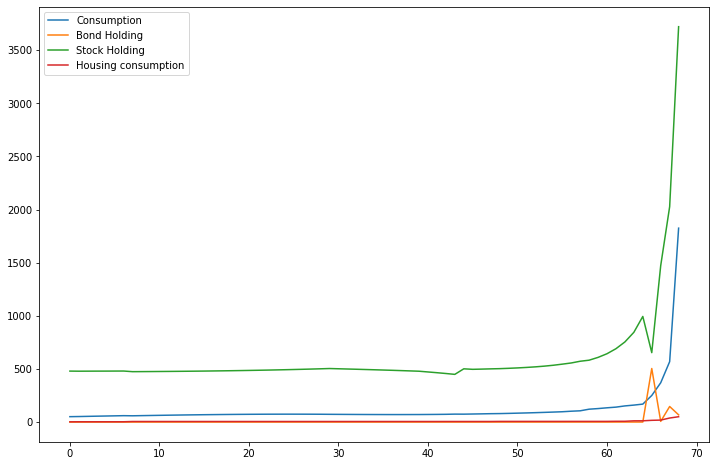

In [30]:
def summaryPlotChoiceVStime(w_level, n_level, h_level, s, e, A, C = cgrid, B = bgrid, K = kgrid,H = hgrid):
    c = []
    b = []
    k = []
    h = []
    for t in range(1,T_max):
        c.append(RS((ws, ns, hs), C[:,:,:,s,e,A,t])([w_level, n_level, h_level])[0])
        b.append(RS((ws, ns, hs), B[:,:,:,s,e,A,t])([w_level, n_level, h_level])[0])
        k.append(RS((ws, ns, hs), K[:,:,:,s,e,A,t])([w_level, n_level, h_level])[0])
        h.append(RS((ws, ns, hs), H[:,:,:,s,e,A,t])([w_level, n_level, h_level])[0])
    plt.figure(figsize = [12,8])
#     plt.plot(c, label = "Consumption")
#     plt.plot(b, label= "Bond Holding")
#     plt.plot(k, label= "Stock Holding")
    plt.plot(h, label = "Housing consumption")
    plt.legend()
    plt.show()
summaryPlotChoiceVStime(500, 600, 2, 1, 1, 1)

### Simulation Part

In [47]:
import quantecon as qe
mc = qe.MarkovChain(Ps)

def action(t, x):
    w,n,h_lag,s,e,A = x
    if A == 1:
        c = RS((ws, ns, hs), cgrid[:,:,:,s,e,A,t],bounds_error=False, fill_value= None)([w, n, h_lag])[0]
        b = RS((ws, ns, hs), bgrid[:,:,:,s,e,A,t],bounds_error=False, fill_value= None)([w, n, h_lag])[0]
        k = RS((ws, ns, hs), kgrid[:,:,:,s,e,A,t],bounds_error=False, fill_value= None)([w, n, h_lag])[0]
        h = RS((ws, ns, hs), hgrid[:,:,:,s,e,A,t],bounds_error=False, fill_value= None)([w, n, h_lag])[0]
    else:
        c = 0
        b = 0
        k = 0
        h = 0
    return (c,b,k,h)

# Define the transition of state
def transition(x, a, t, s_next):
    '''
        Input: x current state: (w, n, s, e, A) 
               a action taken: (c, b, k)
        Output: the next possible states with corresponding probabilities
    '''
    # unpack variable
    c, b, k, h = a
    w, n, h_lag, s, e, A = x
    # variables used to collect possible states and probabilities 
    x_next = []
    prob_next = []
    # Agent is dead at the end of last period
    if A == 0:
        return np.array([0, 0, 0, s_next, 0, 0])
    # Agent is alive 
    else:
        # variables needed
        N = np.sum(Pa[t:])
        discounting = ((1+r_bar)**N - 1)/(r_bar*(1+r_bar)**N)
        Pat = [1-Pa[t], Pa[t]]
        r_bond = r_f[int(s)]
        # calcualte n_next 
        if t < T_R:
            # before retirement agents put 5% of income to 401k
            if e == 1:
                n_next = (n+0.05*y(t,x))*(1+r_bar)
            else:
                n_next = n*(1+r_bar)
                
            # for potential s_next, e_next and A_next 
            r_stock = r_m[int(s), s_next]
            w_next =  b*(1+r_bond) + k*(1+r_stock)
            for e_next in [0,1]:
                for A_next in [0,1]:
                    x_next.append([w_next, n_next, h, s_next, e_next, A_next])
                    prob_next.append(Pat[A_next] * Pe[int(s),s_next,int(e),e_next])    
                
        else:
            # after retirement agents withdraw cash from 401k
            n_next = n*(1+r_bar)-n/discounting
            e_next = 0
            
            # for potential s_next and A_next
            r_stock = r_m[int(s), s_next]
            w_next =  b*(1+r_bond) + k*(1+r_stock)
            for A_next in [0,1]:
                x_next.append([w_next, n_next, h, s_next, e_next, A_next])
                prob_next.append(Pat[A_next])   
        print(len(prob_next))
        return x_next[np.random.choice(len(prob_next), 1, p = prob_next)[0]]

In [48]:
numEcon = 500
sim = 1000
EconStates = [mc.simulate(ts_length=T_max - T_min, init=0) for _ in range(numEcon)]
# simulate an agent age 0 starting with wealth of 20 and 20 in rFund.
def simulateAgent(i):
    # states
    wealth = []
    rFund = []
    employ = []
    live = []
    Salary = []
    # actions 
    Consumption = []
    Bond = []
    Stock = []
    Housing = []
    if np.random.rand() > 0.95:
        x = [20, 0, 2, 0, 0, 1]
    else:
        x = [20, 0, 2, 0, 1, 1]
    econState = EconStates[i//sim]
    for t in range(len(econState)-1):
        s = econState[t]
        s_next = econState[t+1]
        a = action(t, x)
        c, b, k, h = a
        w, n, h_lag, _, e, A = x
        
        wealth.append(w)
        rFund.append(n)
        Consumption.append(c)
        Bond.append(b)
        Stock.append(k)
        Housing.append(h)
        Salary.append(y(t, x))
        employ.append(e)
        live.append(A)
        x = transition(x, a, t, s_next)
    # list of array 
    return np.array([wealth, rFund, Consumption, Bond, Stock, Housing, Salary, employ, live]).T

In [ ]:
%%time 
pool = Pool()
agents = pool.map(simulateAgent, list(range(sim*numEcon)))
pool.close()